# User Groups that we are interested in

1. Users that viewed the offer
    1. Did they complete the offer
        - What types of offers did they complete?
    2. Did they at least have transactions
        - What types of offers did they not complete?
        - Can try to see how many transactions there were and what percentage of the offer they completed.

We need to see what types of users fall into each of these categories to see if the offer type changes their completion status

# Library Imports

In [371]:
import pandas as pd
import numpy as np

from functools import reduce

from sqlalchemy import create_engine

from datetime import date

import matplotlib.pyplot as plt
import seaborn as sns

# Data Loading

In [372]:
conn = create_engine('sqlite:///data/starbucks_data.db')

offers = pd.read_sql('SELECT * FROM offers', conn)
offers_wo_chnl = offers.drop(columns=['offer_notification_channel']).drop_duplicates()

users = pd.read_sql('SELECT * FROM users', conn)

users['user_gender'] = users['user_gender'].fillna('N/A')
user_gender_cats = [ 'N/A', 'O', 'F', 'M' ]
users['user_gender'] = pd.Categorical(users['user_gender'], categories=user_gender_cats, ordered=True)

users['user_age_group'] = users['user_age_group'].fillna('N/A')
user_age_cats = ['N/A', '18-24', '25-34', '35-44', '45-54', '55-64', '65+']
users['user_age_group'] = pd.Categorical(users['user_age_group'], categories=user_age_cats, ordered=True)

user_income_cats = ['N/A', '<50k', '50k-75k', '75k-100k', '>100k']
users['user_income_group'] = pd.Categorical(users['user_income_group'], categories=user_income_cats, ordered=False)

interactions = pd.read_sql('SELECT * FROM interactions', conn)

offer_recv_view_comp = pd.read_sql('offer_recv_view_comp', conn)
offer_recv_view_nocomp = pd.read_sql('offer_recv_view_nocomp', conn)

In [373]:
users

,user_id,user_gender,user_age,user_member_since,user_income,user_tenure,user_age_group,user_income_group
0,68be06ca386d4c31939f3a4f0e3dd783,N/A,NaN,2017-02-12 00:00:00.000000,NaN,1,N/A,N/A
1,0610b486422d4921ae7d2bf64640c50b,F,55.0,2017-07-15 00:00:00.000000,112000.0,1,55-64,>100k
2,38fe809add3b4fcf9315a9694bb96ff5,N/A,NaN,2018-07-12 00:00:00.000000,NaN,0,N/A,N/A
3,78afa995795e4d85b5d9ceeca43f5fef,F,75.0,2017-05-09 00:00:00.000000,100000.0,1,65+,>100k
4,a03223e636434f42ac4c3df47e8bac43,N/A,NaN,2017-08-04 00:00:00.000000,NaN,1,N/A,N/A
...,...,...,...,...,...,...,...,...
16995,6d5f3a774f3d4714ab0c092238f3a1d7,F,45.0,2018-06-04 00:00:00.000000,54000.0,0,45-54,50k-75k
16996,2cb4f97358b841b9a9773a7aa05a9d77,M,61.0,2018-07-13 00:00:00.000000,72000.0,0,55-64,50k-75k
16997,01d26f638c274aa0b965d24cefe3183f,M,49.0,2017-01-26 00:00:00.000000,73000.0,1,45-54,50k-75k
16998,9dc1421481194dcd9400aec7c9ae6366,F,83.0,2016-03-07 00:00:00.000000,50000.0,2,65+,50k-75k


In [374]:
received_offers = interactions[ interactions['intxn_event_type'] == 'offer received' ].copy()
received_offers = received_offers.groupby(['user_id', 'offer_id']).agg({'intxn_event_type': 'count'}).rename(columns={'intxn_event_type': 'received_count'}).reset_index()

received_offers

,user_id,offer_id,received_count
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,1
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,1
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1
...,...,...,...
63283,fffad4f4828548d1b5583907f2e9906b,f19421c1d4aa40978ebb69ca19b0e20d,2
63284,ffff82501cea40309d5fdd7edcca4a07,0b1e1539f2cc45b7b9fa7c272da2e1d7,1
63285,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,3
63286,ffff82501cea40309d5fdd7edcca4a07,9b98b8c7a33c4b65b9aebfe6a799e6d9,1


# Looking into users/offers pairs that were completed

In [375]:
offer_recv_view_comp

,user_id,offer_id,received_event_type,received_time,offer_reward_vs_spend,expiration_time,viewed_event_type,viewed_time,completed_event_type,completed_time
0,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,offer received,168,0.43,336,offer viewed,186.0,offer completed,252.0
1,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,offer received,408,0.25,648,offer viewed,432.0,offer completed,576.0
2,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9,offer received,504,1.00,672,offer viewed,516.0,offer completed,576.0
3,0020c2b971eb4e9188eac86d93036a77,fafdcd668e3743c1bb461111dcafc2a4,offer received,0,0.20,240,offer viewed,12.0,offer completed,54.0
4,0020c2b971eb4e9188eac86d93036a77,4d5c57ea9a6940dd891ad53e9dbe8da0,offer received,408,1.00,528,offer viewed,426.0,offer completed,510.0
...,...,...,...,...,...,...,...,...,...,...
23859,fffad4f4828548d1b5583907f2e9906b,f19421c1d4aa40978ebb69ca19b0e20d,offer received,408,1.00,528,offer viewed,510.0,offer completed,516.0
23860,ffff82501cea40309d5fdd7edcca4a07,fafdcd668e3743c1bb461111dcafc2a4,offer received,0,0.20,240,offer viewed,6.0,offer completed,60.0
23861,ffff82501cea40309d5fdd7edcca4a07,0b1e1539f2cc45b7b9fa7c272da2e1d7,offer received,168,0.25,408,offer viewed,174.0,offer completed,198.0
23862,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,offer received,336,0.20,504,offer viewed,354.0,offer completed,384.0


In [376]:
# getting information on these completed offers
completed_offers = offer_recv_view_comp[ ['user_id', 'offer_id', 'received_event_type'] ].drop_duplicates().copy()
completed_offers_by_user = completed_offers.groupby(['user_id', 'offer_id']).agg({'received_event_type': 'count'}).rename(columns={'received_event_type': 'completed_count'}).reset_index()

completed_offers_by_user

,user_id,offer_id,completed_count
0,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,1
1,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,1
2,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9,1
3,0020c2b971eb4e9188eac86d93036a77,4d5c57ea9a6940dd891ad53e9dbe8da0,1
4,0020c2b971eb4e9188eac86d93036a77,fafdcd668e3743c1bb461111dcafc2a4,1
...,...,...,...
21088,fff7576017104bcc8677a8d63322b5e1,fafdcd668e3743c1bb461111dcafc2a4,1
21089,fffad4f4828548d1b5583907f2e9906b,f19421c1d4aa40978ebb69ca19b0e20d,1
21090,ffff82501cea40309d5fdd7edcca4a07,0b1e1539f2cc45b7b9fa7c272da2e1d7,1
21091,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,1


In [377]:
received_v_completed_by_user = pd.merge(received_offers, completed_offers_by_user, how='outer', on=['user_id', 'offer_id'])
received_v_completed_by_user['completed_percent'] = received_v_completed_by_user['completed_count'] / received_v_completed_by_user['received_count']
received_v_completed_by_user = received_v_completed_by_user.fillna(0)

received_v_completed_by_user

,user_id,offer_id,received_count,completed_count,completed_percent
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1,0.0,0.000000
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,1,0.0,0.000000
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,1,0.0,0.000000
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1,0.0,0.000000
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1,0.0,0.000000
...,...,...,...,...,...
63283,fffad4f4828548d1b5583907f2e9906b,f19421c1d4aa40978ebb69ca19b0e20d,2,1.0,0.500000
63284,ffff82501cea40309d5fdd7edcca4a07,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1.0,1.000000
63285,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,3,1.0,0.333333
63286,ffff82501cea40309d5fdd7edcca4a07,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0.0,0.000000


In [378]:
received_v_completed_by_user = pd.merge( received_v_completed_by_user, offers_wo_chnl, how='left', on=['offer_id'] )
received_v_completed_by_user = pd.merge( received_v_completed_by_user, users, how='left', on=['user_id'] )

received_v_completed_by_user = received_v_completed_by_user[ received_v_completed_by_user['offer_type'] != 'informational' ]

received_v_completed_by_user

,user_id,offer_id,received_count,completed_count,completed_percent,offer_type,offer_spend_minimum,offer_reward,offer_duration,offer_reward_vs_spend,user_gender,user_age,user_member_since,user_income,user_tenure,user_age_group,user_income_group
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1,0.0,0.000000,discount,10,2,168,0.20,M,33.0,2017-04-21 00:00:00.000000,72000.0,1,25-34,50k-75k
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1,0.0,0.000000,bogo,5,5,120,1.00,M,33.0,2017-04-21 00:00:00.000000,72000.0,1,25-34,50k-75k
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1,0.0,0.000000,discount,10,2,240,0.20,M,33.0,2017-04-21 00:00:00.000000,72000.0,1,25-34,50k-75k
5,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,2,0.0,0.000000,bogo,5,5,120,1.00,N/A,NaN,2018-04-25 00:00:00.000000,NaN,0,N/A,N/A
6,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1.0,1.000000,discount,20,5,240,0.25,O,40.0,2018-01-09 00:00:00.000000,57000.0,0,35-44,50k-75k
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63283,fffad4f4828548d1b5583907f2e9906b,f19421c1d4aa40978ebb69ca19b0e20d,2,1.0,0.500000,bogo,5,5,120,1.00,M,34.0,2017-01-23 00:00:00.000000,34000.0,1,25-34,<50k
63284,ffff82501cea40309d5fdd7edcca4a07,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1.0,1.000000,discount,20,5,240,0.25,F,45.0,2016-11-25 00:00:00.000000,62000.0,2,45-54,50k-75k
63285,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,3,1.0,0.333333,discount,10,2,168,0.20,F,45.0,2016-11-25 00:00:00.000000,62000.0,2,45-54,50k-75k
63286,ffff82501cea40309d5fdd7edcca4a07,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0.0,0.000000,bogo,5,5,168,1.00,F,45.0,2016-11-25 00:00:00.000000,62000.0,2,45-54,50k-75k


In [379]:
received_v_completed_by_user.groupby('user_gender', observed=False, dropna=False).count()

,user_id,offer_id,received_count,completed_count,completed_percent,offer_type,offer_spend_minimum,offer_reward,offer_duration,offer_reward_vs_spend,user_age,user_member_since,user_income,user_tenure,user_age_group,user_income_group
user_gender,,,,,,,,,,,,,,,,
N/A,6456,6456,6456,6456,6456,6456,6456,6456,6456,6456,0,6456,0,6456,6456,6456
O,606,606,606,606,606,606,606,606,606,606,606,606,606,606,606,606
F,18207,18207,18207,18207,18207,18207,18207,18207,18207,18207,18207,18207,18207,18207,18207,18207
M,25368,25368,25368,25368,25368,25368,25368,25368,25368,25368,25368,25368,25368,25368,25368,25368


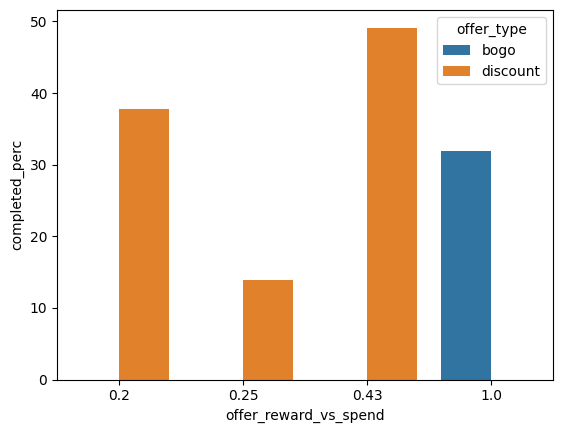

In [402]:
user_feat = 'user_income_group'
offer_feat = 'offer_reward_vs_spend'
offer_type = 'discount'

df = received_v_completed_by_user#[ received_v_completed_by_user['offer_type'] == offer_type ]
agg_df = df.groupby( [ 'offer_type', offer_feat, user_feat], observed=False, dropna=False )[['received_count', 'completed_count']].sum().reset_index()
agg_df['completed_perc'] = agg_df['completed_count'] / agg_df['received_count'] * 100

features_bar = sns.barplot( data=agg_df, x=offer_feat, y='completed_perc', hue='offer_type', errorbar=None )

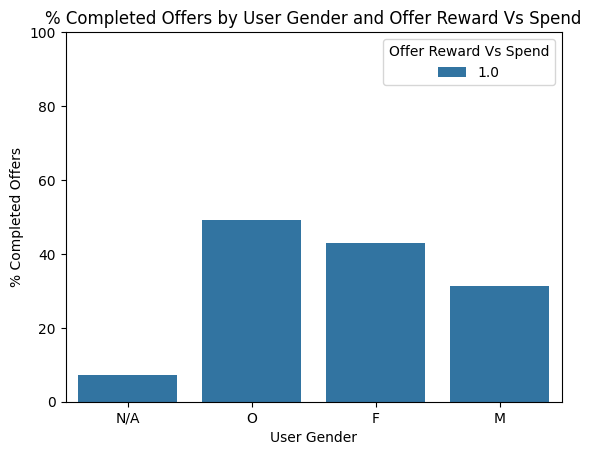

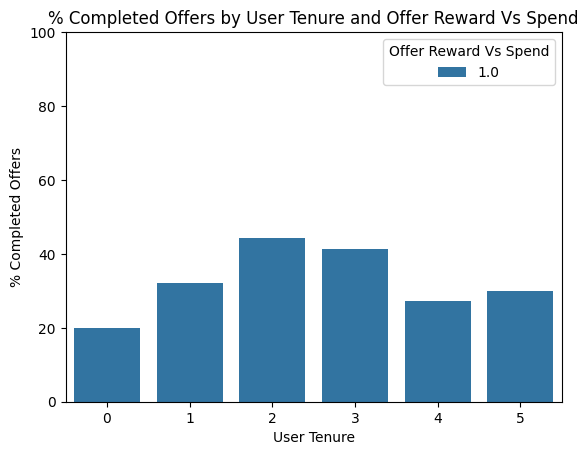

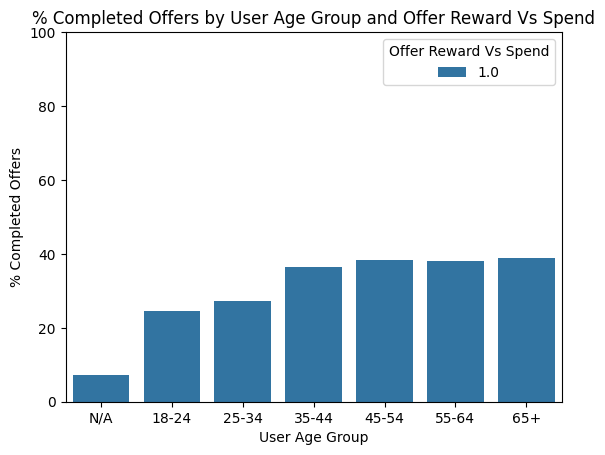

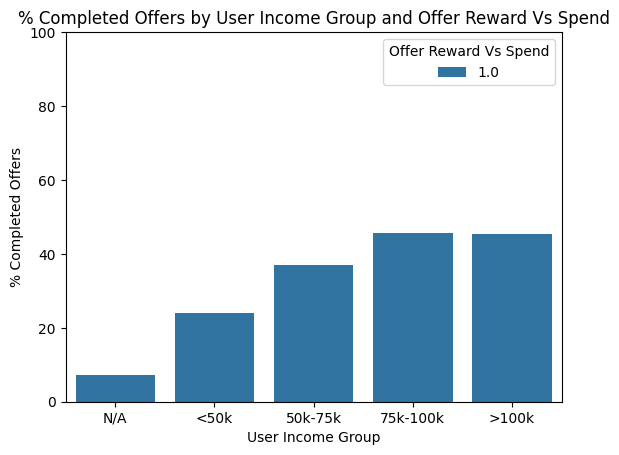

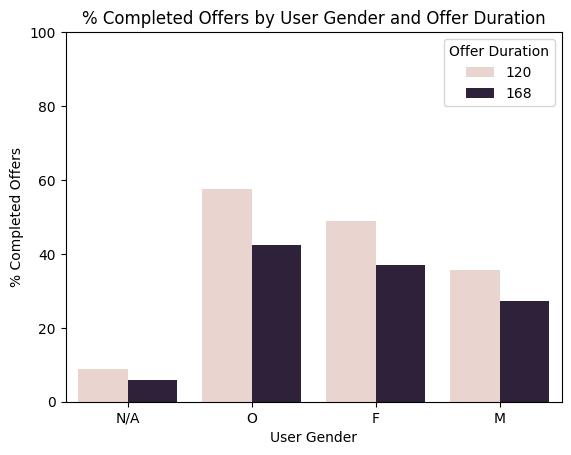

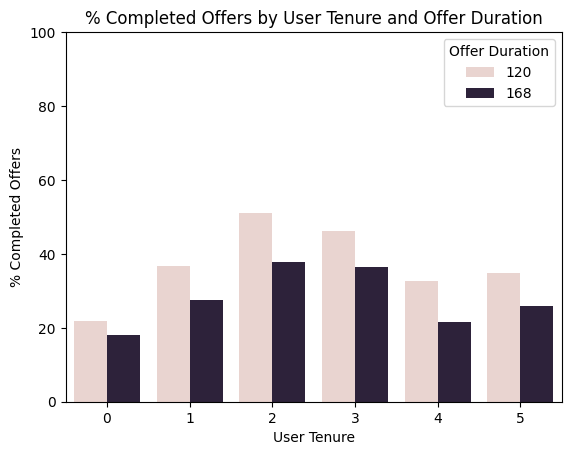

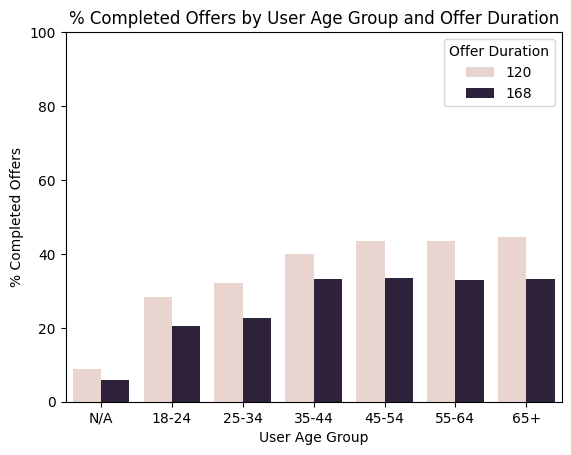

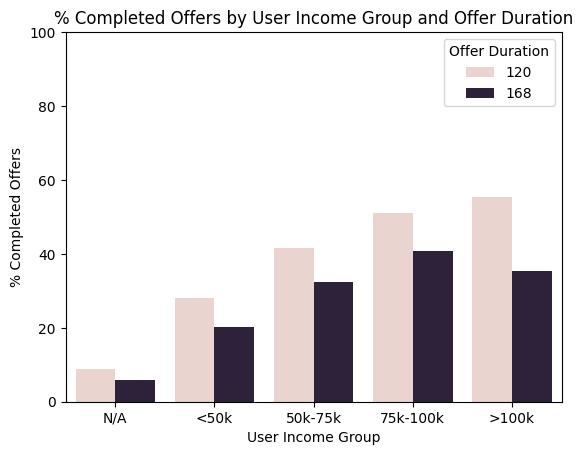

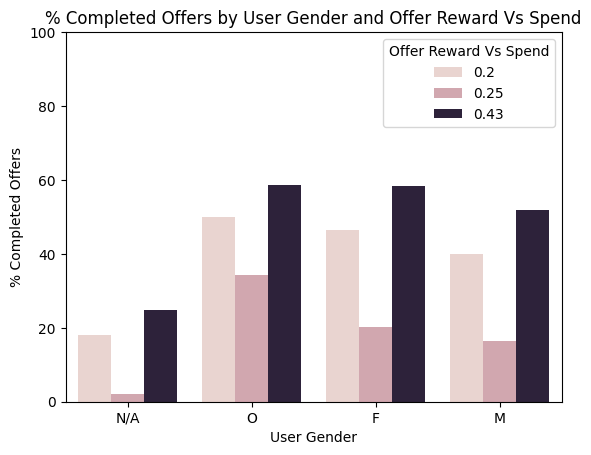

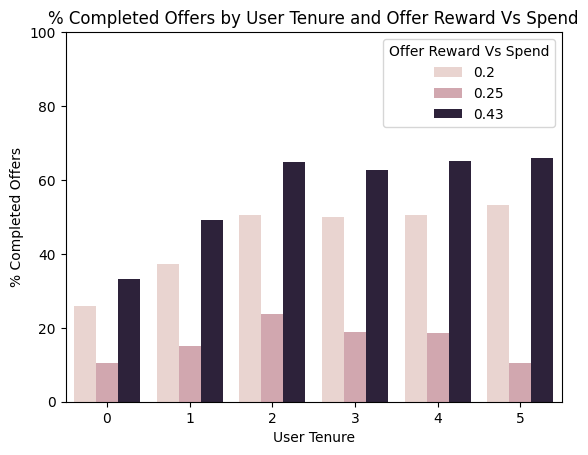

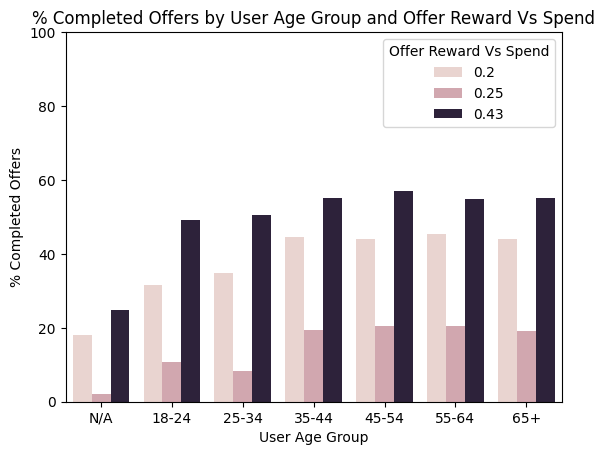

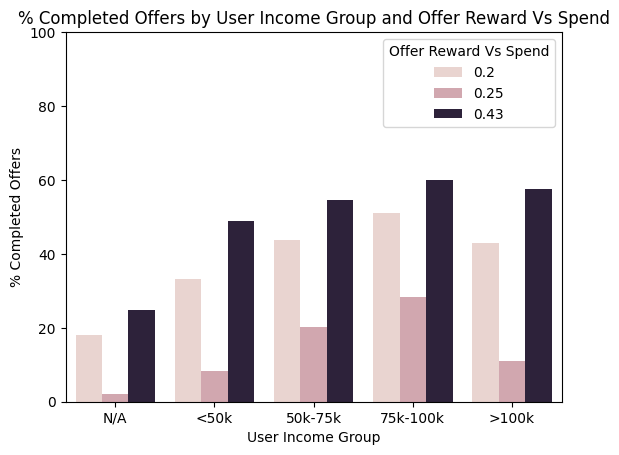

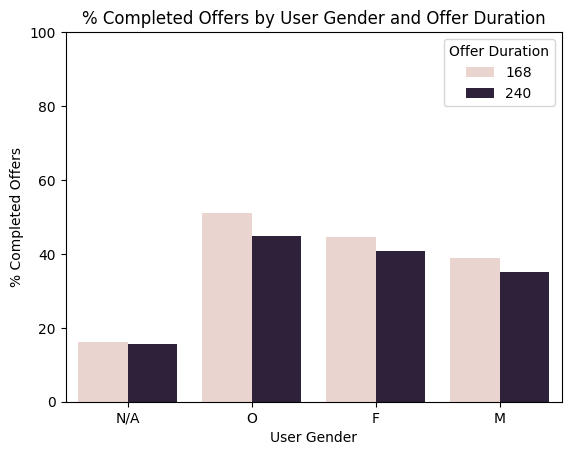

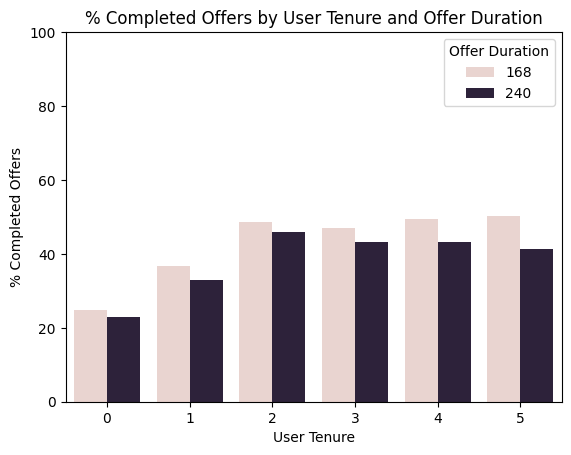

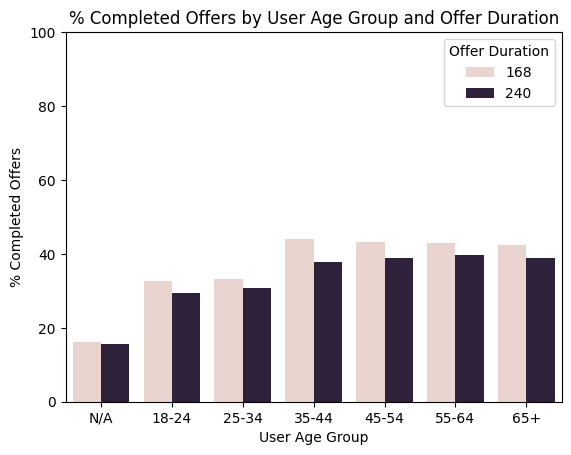

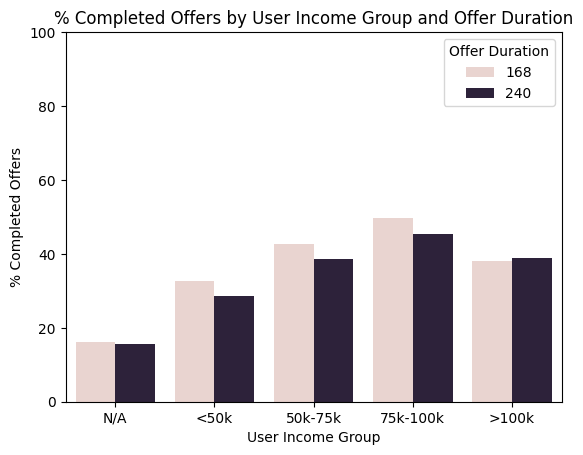

In [380]:
offer_features = [ 'offer_reward_vs_spend', 'offer_duration' ]
user_features = [ 'user_gender', 'user_tenure', 'user_age_group', 'user_income_group' ]

def display_feat_comb_graph( df, offer_feat, user_feat ):
    features_bar = sns.barplot( data=df, x=user_feat, y='completed_perc', hue=offer_feat, errorbar=None )
    user_feat_display = user_feat.replace("_", " ").title()
    offer_feat_display = offer_feat.replace("_", " ").title()

    plt.title( f"% Completed Offers by {user_feat_display} and {offer_feat_display}" )
    plt.ylabel( "% Completed Offers" )
    plt.xlabel( user_feat_display )
    plt.legend( title=offer_feat_display )#.set_title( offer_feat_display )
    plt.ylim(0, 100)
    plt.show()

def generate_feature_combinations( df ):
    for offer_feat in offer_features:
        for user_feat in user_features:
            agg_df = df.groupby( [offer_feat, user_feat], observed=False, dropna=False )[['received_count', 'completed_count']].sum().reset_index()
            agg_df['completed_perc'] = agg_df['completed_count'] / agg_df['received_count'] * 100

            display_feat_comb_graph(agg_df, offer_feat, user_feat)


for offer_type in offers['offer_type'].drop_duplicates().to_list():
    filtered_df = received_v_completed_by_user[ received_v_completed_by_user['offer_type'] == offer_type ]

    if filtered_df.shape[0] > 0:
        generate_feature_combinations( filtered_df )

In [381]:
offer_features = [ 'offer_type', 'offer_spend_minimum', 'offer_reward', 'offer_duration' ]
user_features = [ 'user_gender', 'user_tenure', 'user_age_group', 'user_income_group' ]
received_v_completed = received_v_completed_by_user.groupby( ['offer_type', 'offer_reward_vs_spend', 'offer_duration', 'user_gender', 'user_tenure', 'user_age_group', 'user_income_group'], observed=False, dropna=False ).agg({'received_count': 'sum', 'completed_count': 'sum'}).reset_index()
received_v_completed = received_v_completed[ received_v_completed['received_count'] > 0 ]
received_v_completed['completed_perc'] = round(received_v_completed['completed_count'] / received_v_completed['received_count']*100, 2)

received_v_completed[ (received_v_completed['completed_perc'] >= 50) & (received_v_completed['received_count'] >= 10) ].sort_values( ['completed_perc'], ascending=False )

,offer_type,offer_reward_vs_spend,offer_duration,user_gender,user_tenure,user_age_group,user_income_group,received_count,completed_count,completed_perc
16718,discount,0.43,168,M,3,45-54,75k-100k,15,15.0,100.00
12271,discount,0.20,240,F,2,45-54,<50k,16,15.0,93.75
16747,discount,0.43,168,M,4,35-44,50k-75k,10,9.0,90.00
12501,discount,0.20,240,M,3,18-24,<50k,10,9.0,90.00
14788,discount,0.25,240,F,2,35-44,75k-100k,10,9.0,90.00
...,...,...,...,...,...,...,...,...,...,...
8327,bogo,1.00,120,M,3,65+,50k-75k,92,46.0,50.00
16392,discount,0.43,168,F,0,25-34,50k-75k,26,13.0,50.00
8959,bogo,1.00,168,F,3,65+,>100k,30,15.0,50.00
12432,discount,0.20,240,M,1,18-24,50k-75k,56,28.0,50.00


In [382]:
received_v_completed[ received_v_completed['user_age_group'] == 'N/A' ]

,offer_type,offer_reward_vs_spend,offer_duration,user_gender,user_tenure,user_age_group,user_income_group,received_count,completed_count,completed_perc
7560,bogo,1.00,120,N/A,0,N/A,N/A,468,16.0,3.42
7595,bogo,1.00,120,N/A,1,N/A,N/A,785,70.0,8.92
7630,bogo,1.00,120,N/A,2,N/A,N/A,450,54.0,12.00
7665,bogo,1.00,120,N/A,3,N/A,N/A,248,31.0,12.50
7700,bogo,1.00,120,N/A,4,N/A,N/A,29,3.0,10.34
7735,bogo,1.00,120,N/A,5,N/A,N/A,15,1.0,6.67
8400,bogo,1.00,168,N/A,0,N/A,N/A,507,19.0,3.75
8435,bogo,1.00,168,N/A,1,N/A,N/A,772,46.0,5.96
8470,bogo,1.00,168,N/A,2,N/A,N/A,422,32.0,7.58
8505,bogo,1.00,168,N/A,3,N/A,N/A,226,16.0,7.08


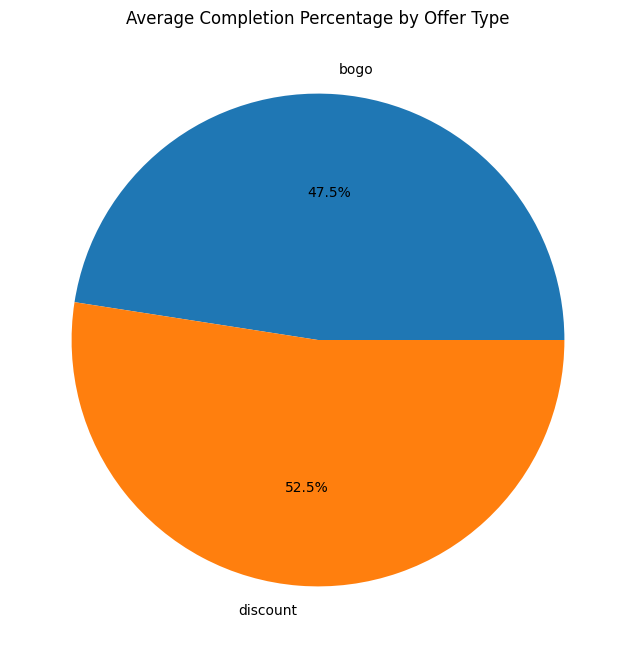

In [383]:
# Aggregate the completed_percent by offer_type for the pie chart
completed_percent_by_offer_type = received_v_completed.groupby('offer_type')['completed_perc'].mean()

# Plot the pie chart
plt.figure(figsize=(8, 8))
plt.pie(
    completed_percent_by_offer_type, 
    labels=completed_percent_by_offer_type.index, 
    autopct='%1.1f%%'
)
plt.title('Average Completion Percentage by Offer Type')
plt.show()

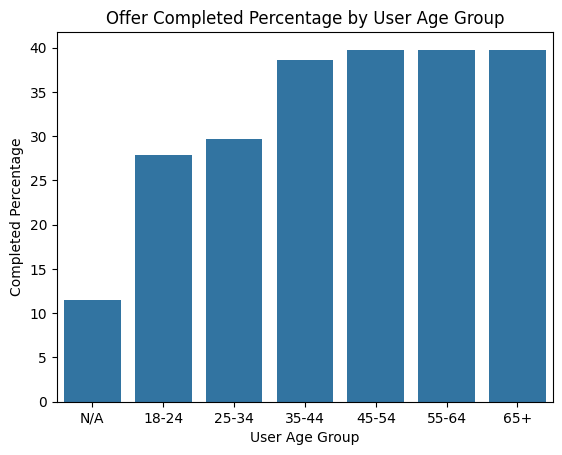

In [384]:
received_v_completed_uag = received_v_completed.groupby(['user_age_group'], observed=False).agg( {'received_count': 'sum', 'completed_count':'sum'} )
received_v_completed_uag['received_perc'] = 100
received_v_completed_uag['completed_perc'] = received_v_completed_uag['completed_count'] / received_v_completed_uag['received_count'] * 100

# bar1 = sns.barplot( data=received_v_completed_uag, x='user_age_group', y='received_perc', errorbar=None, color='white' )
bar2 = sns.barplot( data=received_v_completed_uag, x='user_age_group', y='completed_perc', errorbar=None )

# plt.legend(['Not Completed Percentage', 'Completed Percentage'], bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel( 'User Age Group' )
plt.ylabel( 'Completed Percentage' )
plt.title('Offer Completed Percentage by User Age Group')
plt.show()

In [385]:
received_v_completed_by_user.groupby( ['user_age_group'], observed=False )[['received_count', 'completed_count']].sum()

,received_count,completed_count
user_age_group,,
N/A,7841,905.0
18-24,3170,885.0
25-34,5006,1486.0
35-44,6705,2591.0
45-54,10696,4249.0
55-64,12432,4944.0
65+,15192,6033.0


In [386]:
completed_offer_info = pd.merge(completed_offers, offers_wo_chnl, how='left', left_on='offer_id', right_on='offer_id')
completed_offers_v_users = pd.merge(completed_offer_info, users, how='left', on='user_id')
completed_offers_v_users

,user_id,offer_id,received_event_type,offer_type,offer_spend_minimum,offer_reward,offer_duration,offer_reward_vs_spend,user_gender,user_age,user_member_since,user_income,user_tenure,user_age_group,user_income_group
0,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,offer received,discount,7,3,168,0.43,O,40.0,2018-01-09 00:00:00.000000,57000.0,0,35-44,50k-75k
1,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,offer received,discount,20,5,240,0.25,O,40.0,2018-01-09 00:00:00.000000,57000.0,0,35-44,50k-75k
2,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9,offer received,bogo,5,5,168,1.00,O,40.0,2018-01-09 00:00:00.000000,57000.0,0,35-44,50k-75k
3,0020c2b971eb4e9188eac86d93036a77,fafdcd668e3743c1bb461111dcafc2a4,offer received,discount,10,2,240,0.20,F,59.0,2016-03-04 00:00:00.000000,90000.0,2,55-64,75k-100k
4,0020c2b971eb4e9188eac86d93036a77,4d5c57ea9a6940dd891ad53e9dbe8da0,offer received,bogo,10,10,120,1.00,F,59.0,2016-03-04 00:00:00.000000,90000.0,2,55-64,75k-100k
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21088,fff7576017104bcc8677a8d63322b5e1,fafdcd668e3743c1bb461111dcafc2a4,offer received,discount,10,2,240,0.20,M,71.0,2017-10-31 00:00:00.000000,73000.0,1,65+,50k-75k
21089,fffad4f4828548d1b5583907f2e9906b,f19421c1d4aa40978ebb69ca19b0e20d,offer received,bogo,5,5,120,1.00,M,34.0,2017-01-23 00:00:00.000000,34000.0,1,25-34,<50k
21090,ffff82501cea40309d5fdd7edcca4a07,fafdcd668e3743c1bb461111dcafc2a4,offer received,discount,10,2,240,0.20,F,45.0,2016-11-25 00:00:00.000000,62000.0,2,45-54,50k-75k
21091,ffff82501cea40309d5fdd7edcca4a07,0b1e1539f2cc45b7b9fa7c272da2e1d7,offer received,discount,20,5,240,0.25,F,45.0,2016-11-25 00:00:00.000000,62000.0,2,45-54,50k-75k


In [387]:
completed_offers_by_type_and_user_age = completed_offers_v_users.groupby(['offer_type', 'user_age_group'], observed=False, dropna=False).agg({'offer_id': 'count'}).rename(columns={'offer_id': 'completed_count'}).reset_index()

completed_offers_by_type_and_user_age

,offer_type,user_age_group,completed_count
0,bogo,N/A,290
1,bogo,18-24,388
2,bogo,25-34,676
3,bogo,35-44,1225
4,bogo,45-54,2076
5,bogo,55-64,2341
6,bogo,65+,2941
7,discount,N/A,615
8,discount,18-24,497
9,discount,25-34,810


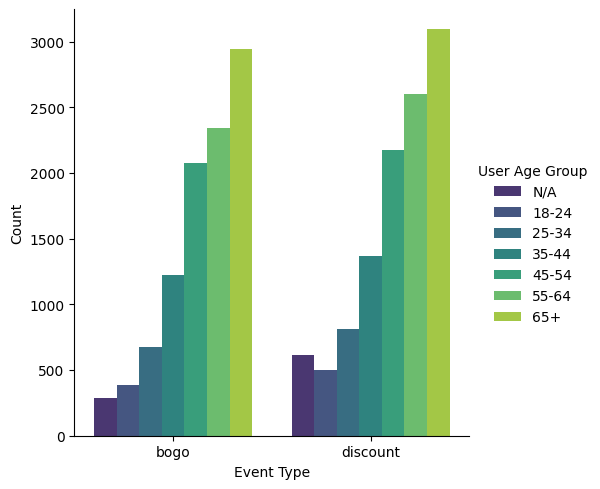

In [388]:
event_type_by_age_group_chart = sns.catplot(
    data=completed_offers_by_type_and_user_age, kind='bar',
    x='offer_type', y='completed_count', 
    hue='user_age_group', 
    height=5, palette='viridis'
)

event_type_by_age_group_chart.set_axis_labels( 'Event Type', 'Count' )
sns.move_legend(event_type_by_age_group_chart, loc='center right', title='User Age Group')

__Need to get percentages__